In [1]:
from datetime import date, datetime, timedelta
import pymysql
import csv
import os
from pandas import DataFrame
import pandas as pd
from sqlalchemy import create_engine
import mysql.connector
from mysql.connector import errorcode
import glob
import logging
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None
# for advanced visualizations
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
#import plotly.figure_factory as ff
# for basic visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import line_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import BigramAssocMeasures, BigramCollocationFinder, TrigramAssocMeasures, TrigramCollocationFinder
import matplotlib.pyplot as plt
from nltk import sent_tokenize
from nltk import pos_tag, sent_tokenize, wordpunct_tokenize
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer

##https://www.kaggle.com/roshansharma/amazon-alexa-reviews


In [4]:
df = pd.read_json('/Users/exue001c/evagit/amazon_healthcare_review/data/review_sample.json',orient='columns')

In [5]:
df.review_date.head()

0       1553126400000
1       1557964800000
10      1571702400000
100     1568592000000
1000    1576627200000
Name: review_date, dtype: int64

### Rating Distribution

In [6]:
#colors = plt.cm.copper(np.linspace(0, 1, 15))
ratings = df['rating'].value_counts().sort_index(ascending=False)

label_rating = ratings.index
size_rating = ratings.values

colors = ['pink', 'lightblue', 'aqua', 'gold', 'crimson']

rating_piechart = go.Pie(labels = label_rating,
                         values = size_rating,
                         marker = dict(colors = colors),
                         name = 'Alexa', hole = 0.3)

rating_df = [rating_piechart]

layout = go.Layout(
           title={
        'text': "Distribution of Ratings for Crutch Pad Helpful Review",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig = go.Figure(data = rating_df,
                 layout = layout)

py.iplot(fig)
display(ratings)

5    1860
4     290
3     138
2      82
1     114
Name: rating, dtype: int64

By looking at the above pie chart, we can infer that most of the Ratings are good for 14 Cruch pad products. Around 74.9% people have given this product 5 Star rating on amazon, which is very good. 11.7% people have given these products a 4 Star Rating, which is also good. that means 74.9+11.7 ~ 87% people have given Cruch pad good rating.

A total of 3.3+4.59 ~8% people did not like Cruch pad they purchased.



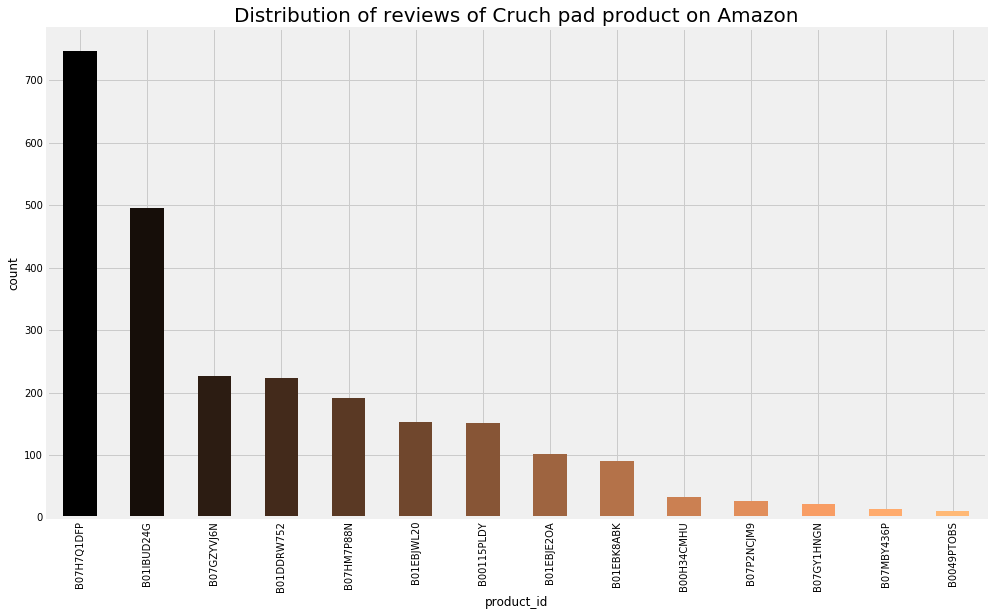

In [7]:
color = plt.cm.copper(np.linspace(0, 1, 15))
df['product_id'].value_counts().plot.bar(color = color, figsize = (15, 9))

plt.title('Distribution of reviews of Cruch pad product on Amazon', fontsize = 20)
plt.xlabel('product_id')
plt.ylabel('count')
plt.show()

The above Bar plot, plots the different cruch pad product with their popularity or no. of counts.

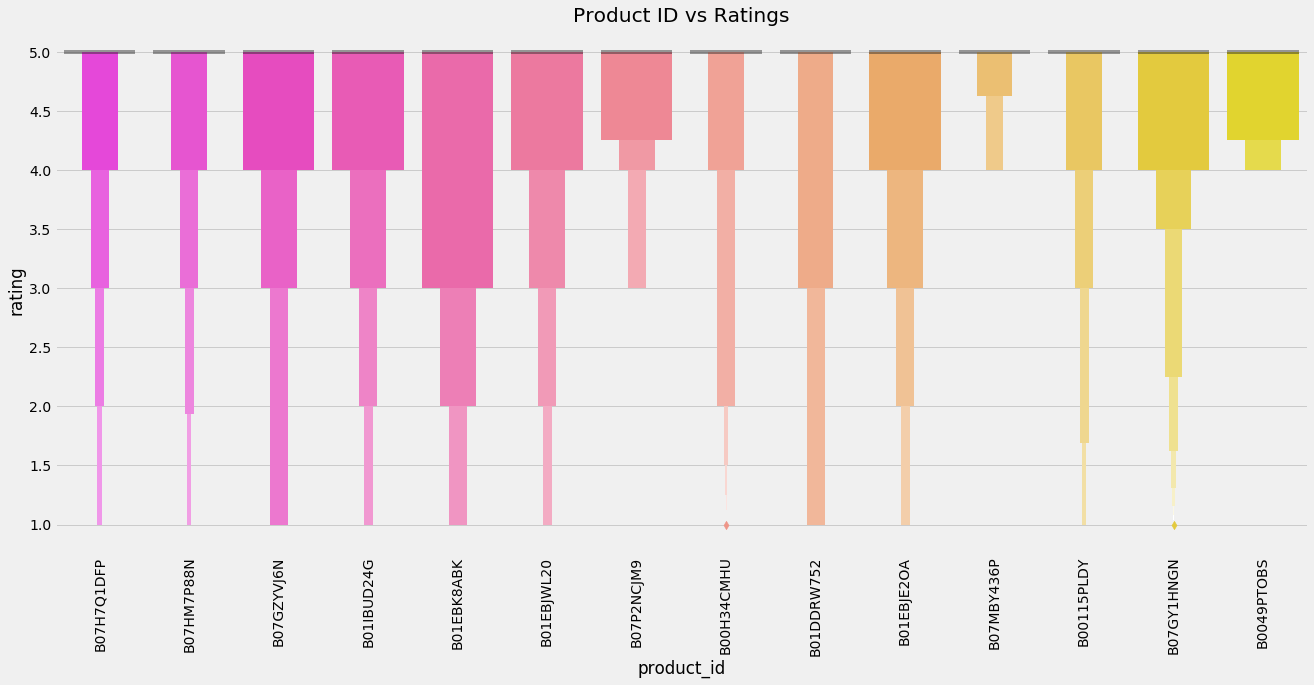

In [8]:
plt.rcParams['figure.figsize'] = (20, 9)
plt.style.use('fivethirtyeight')

sns.boxenplot(df['product_id'], df['rating'], palette = 'spring')
plt.title("Product ID vs Ratings")
plt.xticks(rotation = 90)
plt.show()

The above Box plot, plots the distribution of the rating for each product. 

The above Distribution Plot, shows a distribution of Length of the Reviews/title written by the customers. Most of the Reviews are are pretty short. 

In [9]:
insignificant_taglist1= ['DT', 'CC','PRP','PRP$','IN','.','TO',"''",',','WRB','RP','WP','WDT',
         'EX','UH','$',':','FW','WP$','LS','SYM','VBD','VB','VBP','VBZ','VBG','VBN']
insignificant_taglist2 = ['DT', 'CC','PRP','PRP$','IN','.','TO',"''",',','WRB','RP','WP','WDT',
                                              'EX','UH','$',':','FW','WP$','LS','SYM']
significant_taglist_N =['NN','JJ','JJR','JJS','NNS','NNP','NNPS','PDT','POS']
significant_taglist_V =['RB','RBR','RBS','VB','VBD','VBN','VBP','VBZ','VBG']

In [10]:
def filter_insignificant(chunk, tag_suffixes =insignificant_taglist1):     
    good = [] 
    for word, tag in chunk: 
        if tag in tag_suffixes: 
            continue
        good.append((word, tag))   
    return good


def keep_significant(chunk, tag_suffixes =significant_taglist_N):
    good = [] 
    for word, tag in chunk: 
        if tag not in tag_suffixes: 
            continue
        good.append((word, tag))   
    return good 

In [29]:
df.head()

,helpful_votes,product_id,rating,review,review_date,review_len,title,title_len
0,0,B07H7Q1DFP,4,Got these in hopes that my hands would not hur...,1553126400000,418,"Very soft, saves the hands and under arms",41
1,0,B07HM7P88N,5,The product came very fast and it is very cush...,1557964800000,94,It does work!,13
10,0,B07H7Q1DFP,5,These babies have saved my armpits and the hee...,1571702400000,234,Comfort for longer term crutch use,34
100,0,B07HM7P88N,5,Worked out great.,1568592000000,17,All Good.,9
1000,0,B07GZYVJ6N,5,I purchased these for my daughter when she had...,1576627200000,139,Very Nice Product,17


In [11]:
stop_words = [ x.encode("utf-8") for x in stopwords.words('english') ]
stop_words_skip =["don't","not","aren't","couldn't","didn't","doesn't","hadn't","hasn't","haven't","isn't","mightn't",
                 "mustn't","needn't","shan't","shouldn't","wasn't","weren't","wouldn't","won't",
                  'ain',"no",'nor','aren','couldn','didn','doesn','hadn','hasn','haven','isn','ma','mightn',
                  'mustn','needn','shan','shouldn','wasn','weren','won','wouldn']
self_define_stop_wrods=['nan','crutch','pad','wa']
stop_words=stop_words+self_define_stop_wrods
stop_words2=[x for x in stop_words if x not in stop_words_skip]

In [12]:
def my_tf_color_func(dictionary):
  def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
    col = "hsl(13, 80%%, %d%%)" % ((10000 / (100 + dictionary[word]))+10)
    #print col
    return col
  return my_tf_color_func_inner

In [13]:
def getNGrams(wordlist, n):
    return ['_'.join(wordlist[i:i+n]) for i in range(len(wordlist)-(n-1))]

In [14]:

def word_frequency_chart(words, flag):
    cv = CountVectorizer()
    words = cv.fit_transform(words)
    sum_words = words.sum(axis=0)
    #display(sum_words)


    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
    words_freq_dct = dict(zip(frequency.word, frequency.freq))
    #display(frequency)
    plt.style.use('fivethirtyeight')
    color = plt.cm.copper(np.linspace(0, 1, 30))
    frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
    plt.title("Most Frequently Occuring Words in %s - Top 30"%(flag))
    plt.show()
    return words_freq_dct
    

In [44]:
##test 
from collections import Counter

def word_frequency_chart2(words, flag):

    words = (words
           .str.lower()
           .replace([r'\|',r'\&',r'\-',r'\.',r'\,',r'\''], [' ', '','','','',''], regex=True)
           .str.cat(sep=' ')
           .split()
)
    
    frequency = pd.DataFrame(Counter(words).most_common(30),
                    columns=['word', 'freq'])

    display(frequency)
    words_freq_dct = dict(zip(frequency.word, frequency.freq))
    #display(frequency)
    plt.style.use('fivethirtyeight')
    color = plt.cm.copper(np.linspace(0, 1, 30))
    frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
    plt.title("Most Frequently Occuring Words in %s - Top 30"%(flag))
    plt.show()
    return words_freq_dct


### identify the shape of word cloud

In [17]:
chatbox_mask = np.array(Image.open("/Users/exue001c/evagit/amazon_healthcare_review/image/chatbox2.png"))
#chatbox_mask

In [18]:
def generate_wordcloud(freq, mask,flag):
    word_cloud = WordCloud(stopwords=stop_words2,width = 512, height = 512, background_color='white', mask=mask).generate_from_frequencies(freq)
    plt.style.use('fivethirtyeight')
    # Display the generated image:
    # the matplotlib way:

    plt.title('%s for Cruch pad product on Amazon'%(flag), fontsize = 20, loc='center')

    word_cloud.recolor(color_func=my_tf_color_func(freq), random_state=3)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')

    plt.tight_layout(pad=0)
    plt.show()

### remove key searching words - 'crutch','pad'  from word coud 

In [38]:
def Normalize_Tokens(review_series, flag,n):
    review_list=review_series.tolist()
    v_tokenized = [nltk.word_tokenize(message) for message in review_list]
    v_tokenized_tag = [pos_tag(nltk.wordpunct_tokenize(message.encode("utf-8"))) for message in review_list]
    stop_words = [ x.encode("utf-8") for x in stopwords.words('english') ]
    stop_words_skip =["don't","not","aren't","couldn't","didn't","doesn't","hadn't","hasn't","haven't","isn't","mightn't",
                     "mustn't","needn't","shan't","shouldn't","wasn't","weren't","wouldn't","won't",
                      'ain',"no",'nor','aren','couldn','didn','doesn','hadn','hasn','haven','isn','ma','mightn',
                      'mustn','needn','shan','shouldn','wasn','weren','won','wouldn']
    self_define_stop_wrods=['nan','crutch','pad','wa']
    stop_words=stop_words+self_define_stop_wrods
    stop_words2=[x for x in stop_words if x not in stop_words_skip]
    #display(stop_words2)
    ps = PorterStemmer()
    lemmatizer=WordNetLemmatizer()
    # Create a list for clean messages.
    tokens_len=len(v_tokenized)
    v_prelim = [None] * tokens_len
    v_lemma = [None] * tokens_len
    #v_lemma_counts_per_survey = [None] * tokens_len
    #n_v_lemma_counts_per_survey= [None] * tokens_len
    ngrams_v_lemma = [None] * tokens_len
    # Prep data and Bag-of-Words Analysis
    for i in range(len(v_tokenized)):
        # filter insignificant tag
        #v_prelim[i] = [word for word, tag in filter_insignificant(token_tag[i],filter_tag)]
        # filter insignificant tag
        # 1. Convert to lower case.
        v_prelim[i] = [message.lower() for message in v_tokenized[i]]
        # 2. Remove punctuation and any non-alphabetical characters.
        v_prelim[i] = [word for word in v_prelim[i] if word.isalpha()]
        # 3. Stem words.
        # Lemmitize words and record the word count
        #v_lemma[i] = [ps.stem(word) for word in v_prelim[i]]
        v_lemma[i] = [lemmatizer.lemmatize(word) for word in v_prelim[i]]
        # 4. Remove punctuation and any non-alphabetical characters.
        v_lemma[i] = [word for word in v_lemma[i] if  word not in stop_words2]
        #v_lemma_counts_per_survey[i] = len(v_lemma[i])
                ##ngram 
        ngrams_v_lemma[i] = getNGrams(v_lemma[i], n)
        # 5. Remove stop words for 1gram 
        v_lemma[i] = [word for word in v_lemma[i] if  word not in stop_words]

        
        #n_v_lemma_counts_per_survey[i] = len(ngrams_v_lemma[i])
       
    # Array with length of each survey
    #word_counts_array_lemma = np.array(v_lemma_counts_per_survey)
    #v_lemma_array = np.array(v_lemma)
    #doc_array = np.array(review_series)
    #print('Original Survey Size %s'%(len(v_lemma_array)))

    # Find indices of all messages where there are at least 1 words.
    #valid_v_lemma = np.where(word_counts_array_lemma >= 1)[0]
    #invalid_v_lemma = np.where(word_counts_array_lemma < 1)[0]
    #valid_v_lemma=word_counts_array_lemma
    #print('Survey Size W Valid Verbatim %s'%len(valid_v_lemma))
    #print('--------------Read invalid Verbatim ')
    #for i in range(30):
        #print (v_lemma_array[invalid_v_lemma][i],'\n')
        #print (doc_array[invalid_v_lemma][i],'\n')
    # Convert the array back to a list.

    # Join words in each message into a single character string.
    ngrams_v_lemma_clean_list = [' '.join(d) for d in ngrams_v_lemma]
    v_lemma_clean_list = [' '.join(d) for d in v_lemma]
    orig_doc_clean_list=[''.join(d) for d in review_list]
    #print(v_lemma_clean_list[:10])
    #print(orig_doc_clean_list[:10])
    lema_orig_list = [[i , j, k] for i, j,k in zip(v_lemma_clean_list,ngrams_v_lemma_clean_list,orig_doc_clean_list)] 
    lema_orig_df = pd.DataFrame.from_records(lema_orig_list, columns=['one_gram_lema_text','n_gram_lema_text','orig_text'])
    #print('--------------Verbatim after Lemmatization')
    #for i in range(5):
       # print(i, v_lemma_clean[i],'\n')
       # print(i, v_lemma_clean_list[i],'\n')
       # print (document[i],'\n')
   
    freq=word_frequency_chart(v_lemma_clean_list, flag)
    #freq2=word_frequency_chart2(lema_orig_df.one_gram_lema_text, flag)
    #display(freq)
    generate_wordcloud(freq,chatbox_mask, flag)
    n_freq = word_frequency_chart(ngrams_v_lemma_clean_list, flag)
    generate_wordcloud(n_freq,chatbox_mask, flag)
    #n_freq2 = word_frequency_chart2(lema_orig_df.n_gram_lema_text, flag)
    generate_wordcloud(n_freq2,chatbox_mask, flag)

        
    return lema_orig_df



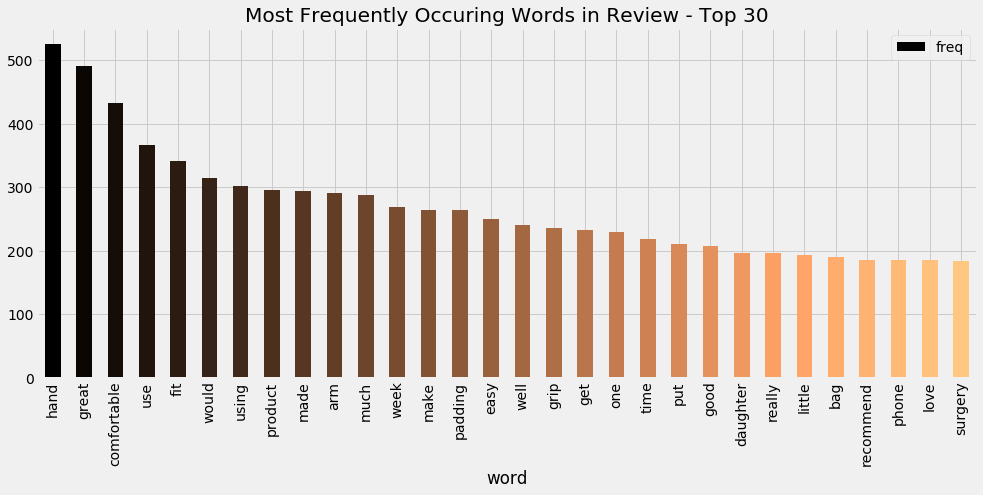

,word,freq
0,hand,525
1,great,491
2,comfortable,433
3,use,366
4,fit,341
5,would,315
6,using,302
7,product,295
8,made,294
9,arm,291


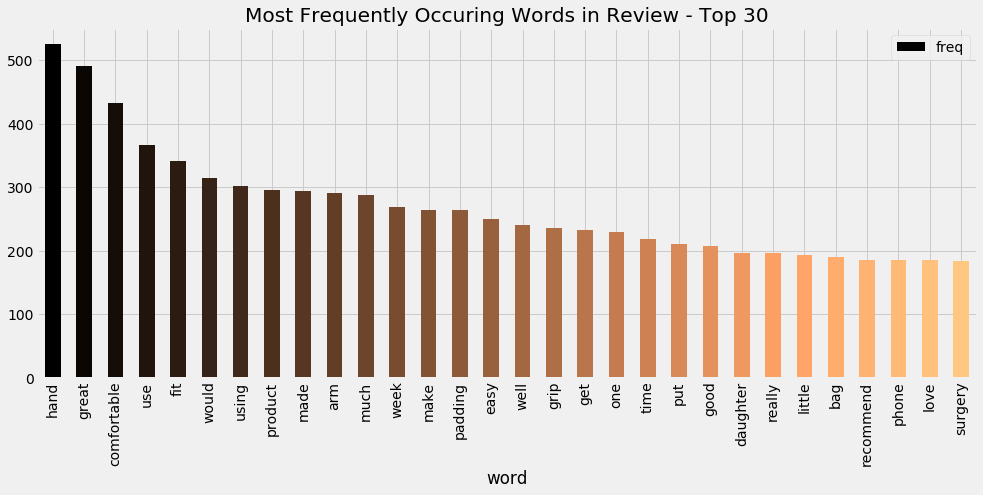

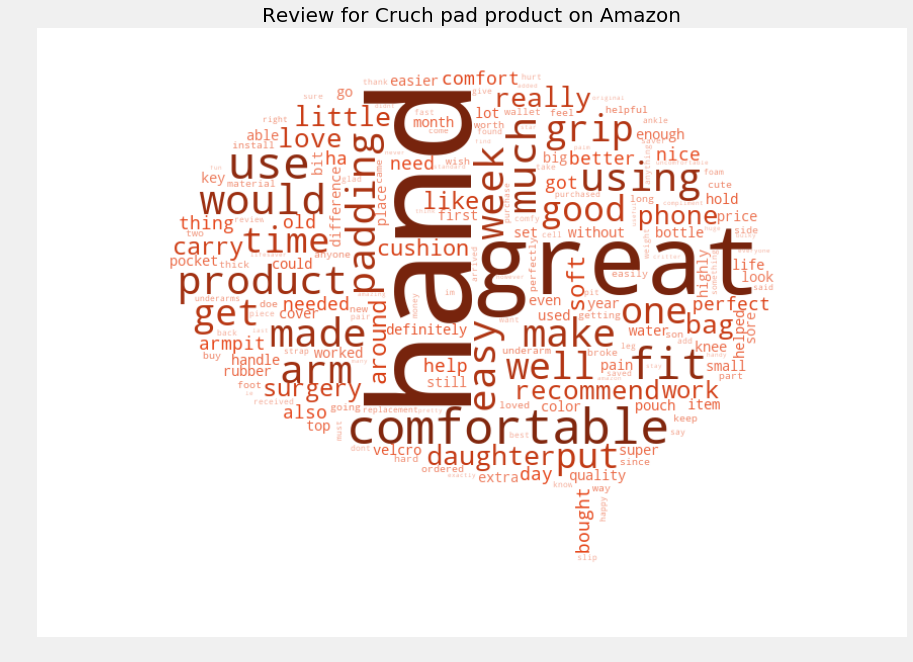

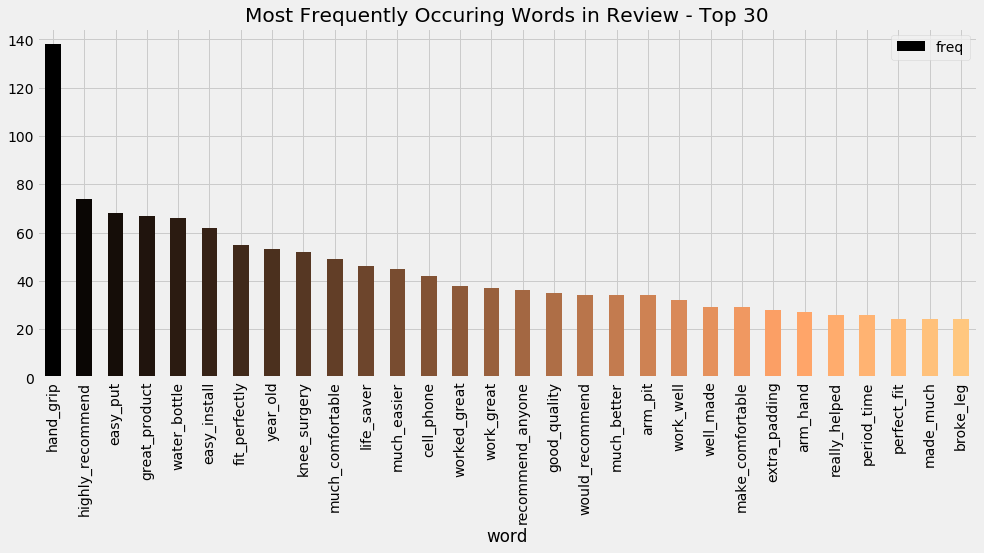

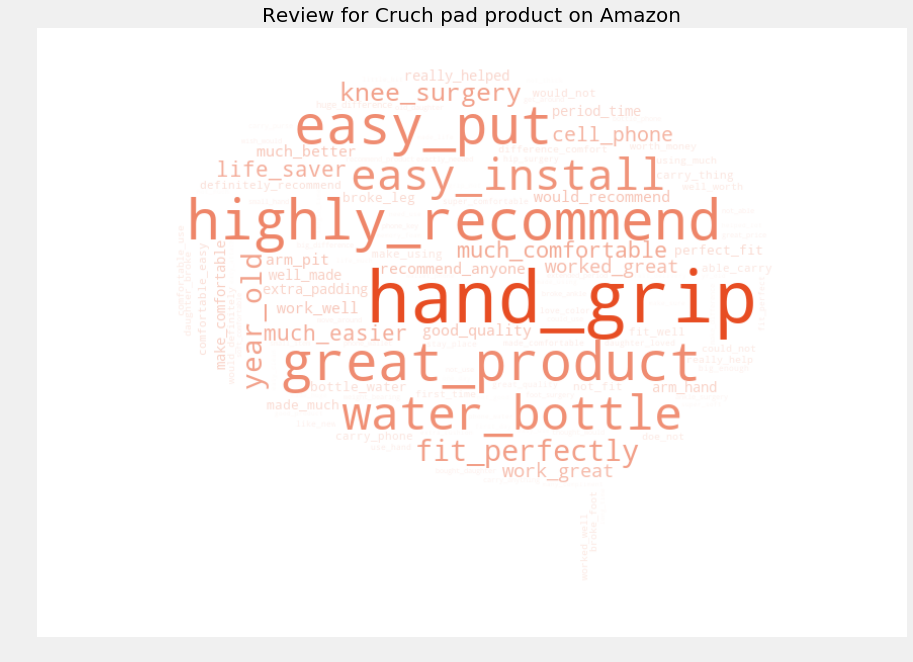

,word,freq
0,hand_grip,138
1,highly_recommend,74
2,easy_put,68
3,great_product,67
4,water_bottle,66
5,easy_install,62
6,fit_perfectly,55
7,year_old,53
8,knee_surgery,52
9,much_comfortable,49


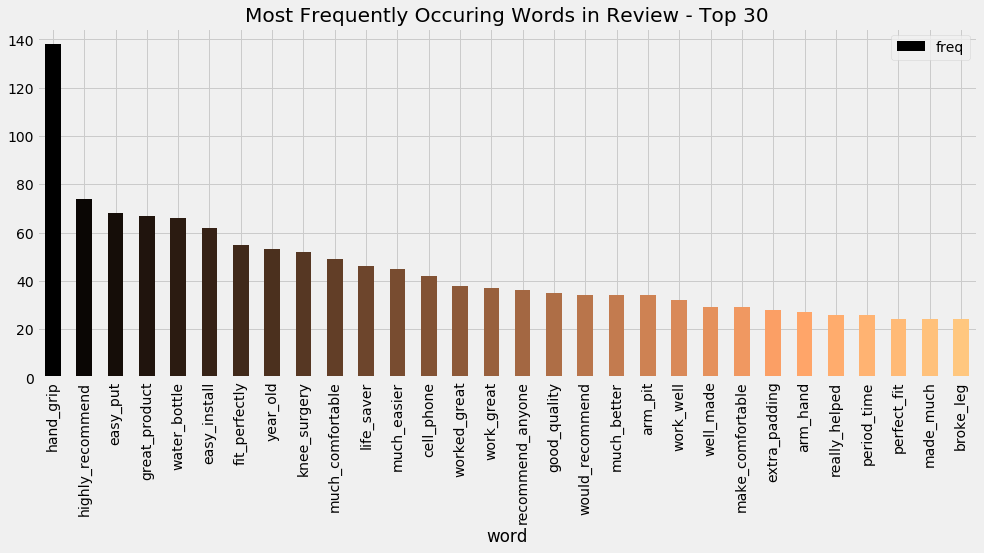

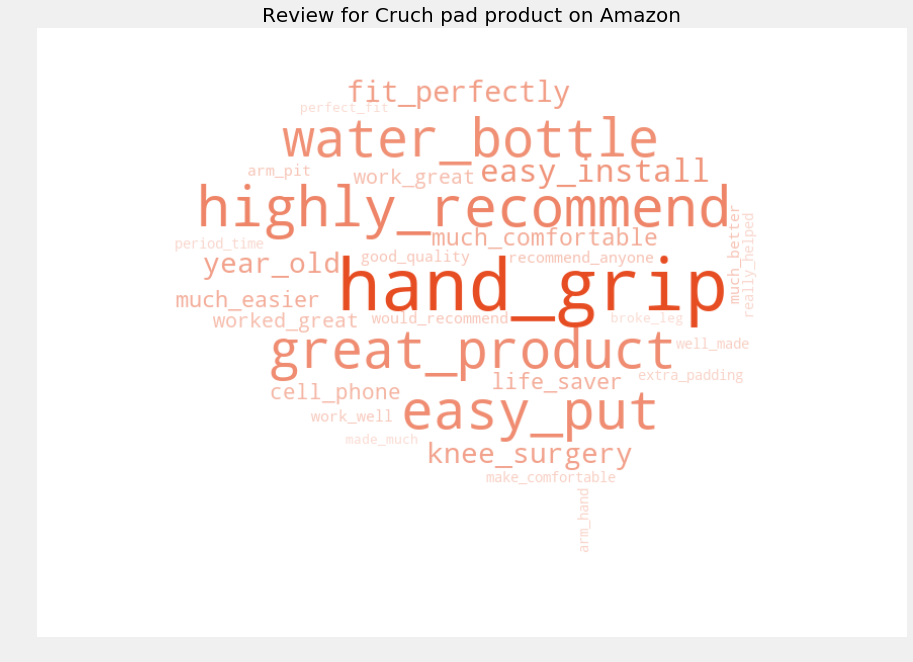

In [45]:
review_transfered = Normalize_Tokens(df['review'] , 'Review',2)
#title_transfered = Normalize_Tokens(df['title'] , 'Title',2)

The Above Word Frequency Barchart and Wordcloud give us a rough idea about what customers mentioned most in their review and review title

We can see that 






In [88]:
result = pd.concat([df,review_transfered, title_transfered], axis=1, sort=False)
display(result)


,helpful_votes,product_id,rating,review,review_date,review_len,title,title_len,one_gram_lema_text,n_gram_lema_text,orig_text,one_gram_lema_text,n_gram_lema_text,orig_text
0,0,B07H7Q1DFP,4,Got these in hopes that my hands would not hur...,1553126400000,418,"Very soft, saves the hands and under arms",41,got hope hand would hurt using comfortable han...,got_hope hope_hand hand_would would_not not_hu...,Got these in hopes that my hands would not hur...,soft save hand arm,soft_save save_hand hand_arm,"Very soft, saves the hands and under arms"
1,0,B07HM7P88N,5,The product came very fast and it is very cush...,1557964800000,94,It does work!,13,product came fast cushy palm hand armpit,product_came came_fast fast_cushy cushy_palm p...,The product came very fast and it is very cush...,doe work,doe_work,It does work!
2,0,B07HM7P88N,5,My daughter had to look for support for her cr...,1553385600000,143,My daughter loves it. Best support for your cr...,53,baby saved armpit heel hand recovering knee su...,baby_saved saved_armpit armpit_heel heel_hand ...,These babies have saved my armpits and the hee...,comfort longer term use,comfort_longer longer_term term_use,Comfort for longer term crutch use
3,0,B01IBUD24G,5,"I'm a student in college, and this was super h...",1523577600000,104,and this was super helpful to carry around my ...,71,worked great,worked_great,Worked out great.,good,,All Good.
4,3,B01IBUD24G,4,The crutch bag gets five stars for being super...,1500076800000,595,"Great idea and super handy, but recommended wi...",62,purchased daughter surgery leg helpful adding ...,purchased_daughter daughter_surgery surgery_le...,I purchased these for my daughter when she had...,nice product,nice_product,Very Nice Product
5,0,B07HM7P88N,4,"When ever a friend needs crutches, this will b...",1574553600000,659,Great pressure relief for your hands,36,made carrying phone wallet even bottle water s...,made_carrying carrying_phone phone_wallet wall...,"This made carrying my phone, wallet, or even a...",awesome,,Awesome
6,3,B01EBJWL20,5,These are a MUST for my crutches after bunion ...,1507248000000,284,These are a MUST for my crutches after bunion ...,57,didnt fit right bulky tight closed,didnt_fit fit_right right_bulky bulky_not not_...,They didnt fit right; bulky and not tight closed,made well,not_made made_well,Not made well
7,0,B07H7Q1DFP,5,The product was perfect and served the needs i...,1554854400000,57,Work great!,11,nice add comfort much thought would,nice_not not_add add_comfort comfort_much much...,"Nice, the do not add comfort as much as I thou...",two star,two_star,Two Stars
8,0,B07GZYVJ6N,5,Did the job!,1560816000000,12,Good padding,12,,,Crutches,comfort,,Comfort
9,1,B01DDRW752,5,https://www.amazon.com/dp/B01DDRW752/ref=cm_cr...,1480723200000,225,Fit to a T,10,year old daughter broke foot place biggest pro...,year_old old_daughter daughter_broke broke_foo...,My 9 year old daughter broke her foot in 3 pla...,great product,great_product,Great product


In [89]:
result.to_csv('/Users/exue001c/evagit/amazon_healthcare_review/data/review_cleaned.csv')